In [4]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from data_proccessing import  valid_loader,train_loader, labels
from helper import train, evaluate
import os

In [5]:
num_classes = len(labels)  # Example number of classes

torch.manual_seed(43)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define ResNet model
alexnet = models.alexnet(pretrained=True)

# Modify the last layer for multi-class classification
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(num_features, num_classes),  # New fully connected layer
    nn.Sigmoid()  # Add Sigmoid activation
)

# Freeze the weights of the pre-trained layers
for param in alexnet.parameters():
    param.requires_grad = False

# Unfreeze the weights of the last layer
for param in alexnet.classifier.parameters():
    param.requires_grad = True

alexnet.to(device)

# Print the model architecture
print(alexnet)

c:\Users\mandi\anaconda3\envs\adl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mandi\anaconda3\envs\adl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
# Clear CUDA memory
torch.cuda.empty_cache()

In [18]:
# Paths for saving
save_dir = "models/alexnet"
os.makedirs(save_dir, exist_ok=True)

# Define Params
criterion = nn.BCELoss()
num_epochs = 15
learning_rates = [0.001, 0.0005]

# Track losses for visualization
train_losses_dict = {}
valid_losses_dict = {}

# Iterate over different learning rates
for lr in learning_rates:
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, alexnet.parameters()), lr=lr)

    best_valid_loss = float('inf')
    train_losses = []  
    valid_losses = []  
    
    for epoch in range(num_epochs):
        avg_train_loss = train(alexnet, train_loader, optimizer, criterion, device)
        train_losses.append(avg_train_loss)
        
        valid_loss = evaluate(alexnet, valid_loader, criterion, device)
        valid_losses.append(valid_loss)
        
        # Print validation loss
        print(f'Learning Rate: {lr}, Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {valid_loss:.4f}')
        
        # Save the best model if validation loss improves
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(alexnet.state_dict(), os.path.join(save_dir, f'best_model_lr_{lr}.pt'))

    # Store losses for visualization
    train_losses_dict[lr] = train_losses
    valid_losses_dict[lr] = valid_losses

# Save losses dictionaries for visualization later
torch.save(train_losses_dict, os.path.join(save_dir, 'train_losses.pt'))
torch.save(valid_losses_dict, os.path.join(save_dir, 'valid_losses.pt'))

Learning Rate: 0.001, Epoch: 1, Train Loss: 0.3782, Validation Loss: 0.3758
Learning Rate: 0.001, Epoch: 2, Train Loss: 0.3658, Validation Loss: 0.3831
Learning Rate: 0.001, Epoch: 3, Train Loss: 0.3618, Validation Loss: 0.3590
Learning Rate: 0.001, Epoch: 4, Train Loss: 0.3566, Validation Loss: 0.3547
Learning Rate: 0.001, Epoch: 5, Train Loss: 0.3491, Validation Loss: 0.3596
Learning Rate: 0.001, Epoch: 6, Train Loss: 0.3440, Validation Loss: 0.3460
Learning Rate: 0.001, Epoch: 7, Train Loss: 0.3427, Validation Loss: 0.3579
Learning Rate: 0.001, Epoch: 8, Train Loss: 0.3369, Validation Loss: 0.3351
Learning Rate: 0.001, Epoch: 9, Train Loss: 0.3356, Validation Loss: 0.3489
Learning Rate: 0.001, Epoch: 10, Train Loss: 0.3318, Validation Loss: 0.3322
Learning Rate: 0.001, Epoch: 11, Train Loss: 0.3262, Validation Loss: 0.3386
Learning Rate: 0.001, Epoch: 12, Train Loss: 0.3217, Validation Loss: 0.3340
Learning Rate: 0.001, Epoch: 13, Train Loss: 0.3229, Validation Loss: 0.3436
Learning

In [6]:
from data_proccessing import test_loader
from helper import test
import pandas as pd

save_dir = "models/alexnet"
# Define Params
criterion = nn.BCELoss()
num_epochs = 15
alexnet.to(device)

learning_rates = [0.001, 0.0005]
for lr in learning_rates:
    model_path = os.path.join(save_dir, f'best_model_lr_{lr}.pt')  # Change the filename accordingly
    alexnet.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    metrics, loss = test(alexnet, test_loader, criterion, device)


    print(metrics, loss)

    Precision  Accuracy    Recall  F1-score
0    0.769231  0.827314  0.119760  0.207254
1    0.733333  0.891648  0.106796  0.186441
2    1.000000  0.881490  0.027778  0.054054
3    0.769231  0.924379  0.421053  0.544218
4    0.916667  0.774266  0.052381  0.099099
5    0.736842  0.927765  0.191781  0.304348
6    0.583333  0.900677  0.077778  0.137255
7    0.500000  0.946953  0.021277  0.040816
8    0.724138  0.727991  0.082677  0.148410
9    1.000000  0.892777  0.030612  0.059406
10   0.000000  0.932280  0.000000  0.000000
11   1.000000  0.882619  0.009524  0.018868
12   1.000000  0.882619  0.028037  0.054545
13   1.000000  0.897291  0.010870  0.021505 0.3381124937108585
    Precision  Accuracy    Recall  F1-score
0    1.000000  0.837472  0.137725  0.242105
1    0.730159  0.916479  0.446602  0.554217
2    1.000000  0.888262  0.083333  0.153846
3    0.825000  0.922122  0.347368  0.488889
4    0.852941  0.817156  0.276190  0.417266
5    0.718750  0.933409  0.315068  0.438095
6    0.687500

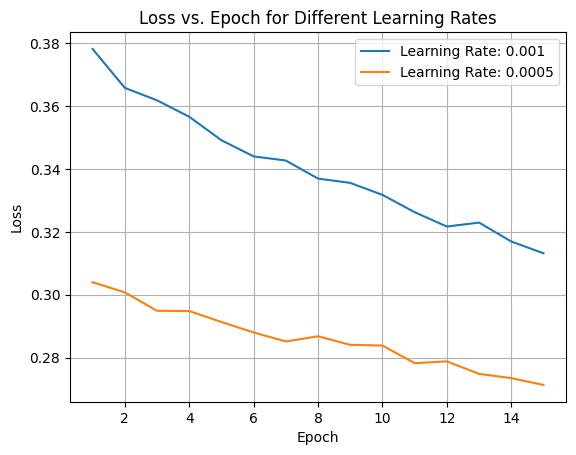

In [7]:
from helper import visualise_loss

save_dir = "models/alexnet/"
model_path = os.path.join(save_dir, f'train_losses.pt')  # Change the filename accordingly
visualise_loss(model_path)

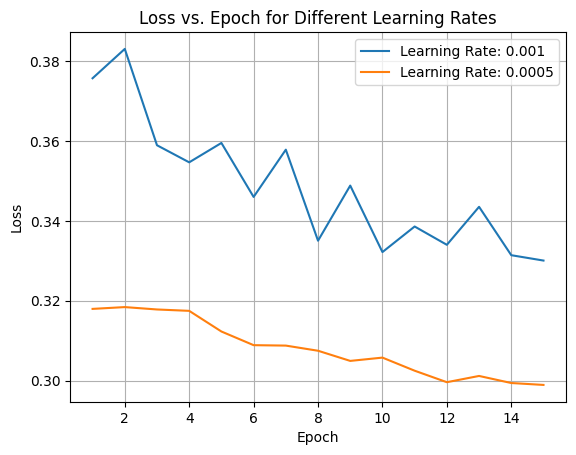

In [8]:
save_dir = "models/alexnet/"
model_path = os.path.join(save_dir, f'valid_losses.pt')  # Change the filename accordingly
visualise_loss(model_path)